In [63]:
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [64]:
# Read the raw data
df = pd.read_csv('~/Desktop/raw_data/tankmodule.csv')[5:]
dfs = pd.read_csv('~/Desktop/raw_data/snap_ads.csv')[520:]

# Keep only a single channel for both
df = df[df['about_node_name'] == 'buffer-depth1']
dfs = dfs[dfs['channel'] == 'channel2']

In [65]:
# Recompute the temperature from the voltage
def temp_beta(r_therm_kohms: float, fahrenheit: bool=True) -> float:
    t0, r0, beta = 298, 10, 3977
    r_therm = r_therm_kohms
    temp_c = 1 / ((1/t0) + (math.log(r_therm/r0) / beta)) - 273
    temp_f = 32 + (temp_c * 9/5)
    return round(temp_f, 3) if fahrenheit else round(temp_c, 3)

def thermistor_resistance(volts):
    r_fixed = 5.65
    r_therm = 1/((3.3/volts-1)/r_fixed)
    return r_therm

df['adjusted_temp'] = [temp_beta(thermistor_resistance(v)) for v in list(df['volts'])]

In [66]:
# Resample and merge
hour_start_s = min(min(df['timestamp']), min(dfs['timestamp']))
hour_end_s = max(max(df['timestamp']), max(dfs['timestamp']))

timestep_seconds = 1
num_points = int((hour_end_s - hour_start_s) / (timestep_seconds) + 1)
sync_times = np.linspace(hour_start_s, hour_end_s, num_points)
sync_times_dt = pd.to_datetime(sync_times, unit='s', utc=True)
sync_times_dt = [x.tz_convert('America/New_York').replace(tzinfo=None) for x in sync_times_dt]

sync_readings = {'times': sync_times}

# Add Pico readings
new_df = {'times': list(df['timestamp']), 'values': list(df['adjusted_temp'])}
new_df['times'] = pd.to_datetime(new_df['times'], unit='s', utc=True)
new_df['times'] = [x.tz_convert('America/New_York') for x in new_df['times']]
new_df['times'] = [x.replace(tzinfo=None) for x in new_df['times']]   
merged = pd.merge_asof(
    pd.DataFrame({'times': sync_times_dt}),
    pd.DataFrame(new_df).ffill(),
    on='times',
    direction='backward'
)
sync_readings['pico'] = list(merged['values'])

# Add ADS readings
new_df = {'times': list(dfs['timestamp']), 'values': list(dfs['temperature_f'])}
new_df['times'] = pd.to_datetime(new_df['times'], unit='s', utc=True)
new_df['times'] = [x.tz_convert('America/New_York') for x in new_df['times']]
new_df['times'] = [x.replace(tzinfo=None) for x in new_df['times']]   
merged = pd.merge_asof(
    pd.DataFrame({'times': sync_times_dt}),
    pd.DataFrame(new_df).ffill(),
    on='times',
    direction='backward'
)
sync_readings['ADS'] = list(merged['values'])

final_df = pd.DataFrame(sync_readings)

RMSE: 3.887°F


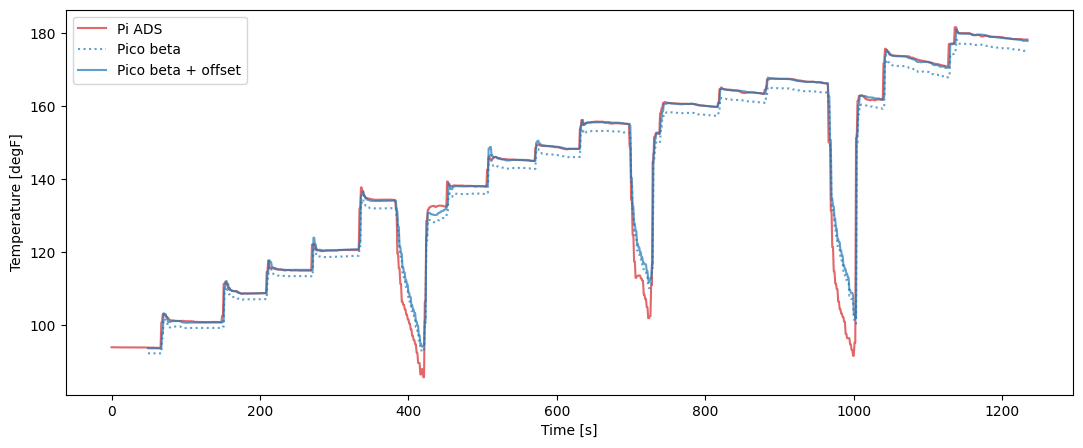

,times,pico,ADS,pico_adjusted,error
0,0.0,NaN,94.007136,NaN,NaN
1,1.0,NaN,94.007136,NaN,NaN
2,2.0,NaN,93.987760,NaN,NaN
3,3.0,NaN,93.987760,NaN,NaN
4,4.0,NaN,93.987760,NaN,NaN
...,...,...,...,...,...
1230,1230.0,175.261,178.338547,178.012017,3.077547
1231,1231.0,175.261,178.338547,178.012017,3.077547
1232,1232.0,175.241,178.338547,177.991683,3.097547
1233,1233.0,175.241,178.338547,177.991683,3.097547


In [68]:
final_df['pico_adjusted'] = final_df['pico'].apply(lambda t: t+t/60-0.17)

rmse = np.sqrt(np.mean((final_df['ADS'] - final_df['pico_adjusted'])**2))
print(f"RMSE: {rmse:.3f}°F")


final_df['error'] = final_df['ADS'] - final_df['pico']
final_df['times'] = final_df['times'] - final_df['times'][0]

fig, ax = plt.subplots(1,1, figsize=(13,5))
ax.plot(final_df['times'], final_df['ADS'], label='Pi ADS', color='tab:red', alpha=0.7)
ax.plot(final_df['times'], final_df['pico'], label='Pico beta', linestyle='dotted', alpha=0.7)
ax.plot(final_df['times'], final_df['pico_adjusted'], label='Pico beta + offset', color='tab:blue', alpha=0.7)
# ax2 = ax.twinx()
# ax2.plot(final_df['error'], color='tab:green', alpha=0.5, label='Error')
# ax2.set_ylim([0,5])
ax.legend()
plt.ylabel("Temperature [degF]")
plt.xlabel("Time [s]")
plt.show()

display(final_df)